In [1]:
from __future__ import annotations

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

In [2]:
df = (pd
    .read_csv(
        'data/crosswriters.csv', 
        encoding='utf-8', 
        usecols=['text', 'author', 'author_gender', 'reader_age_group']
    )
    .astype({
        'author': 'category', 
        'author_gender': 'category', 
        'reader_age_group': 'category'
    })
)
df.sample(10)

,text,author,author_gender,reader_age_group
6114,because of her. andrew did not anticipate havi...,J.K. Rowling,F,adult
5950,"reception, right before i came over to talk to...",J.K. Rowling,F,adult
2164,he simply wanted to go home. he didn’t care th...,Anne Fine,F,child
1195,your age!’ i didn’t like to tell them that way...,Anne Fine,F,adult
1465,down in the pockets of her winter coat. it did...,Anne Fine,F,child
5773,"for one nasty moment, harry thought that hagri...",J.K. Rowling,F,child
6056,scotland yard. they would need a long statemen...,J.K. Rowling,F,adult
344,in silver foil and silver slippers passed out ...,David Almond,M,child
1572,"my aunty jean, who was forever twisting hersel...",Anne Fine,F,adult
3561,to roast across the fire for the two of them. ...,Philip Pullman,M,child


## SVM 

### Child vs Adult

In [3]:
print("Before:", df['reader_age_group'].value_counts(), sep="\n", end="\n\n")

enc = LabelEncoder()
enc.fit(df['reader_age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['reader_age_group'] = enc.transform(df['reader_age_group'])

print("After:", df['reader_age_group'].value_counts(), sep="\n")
encoded_labels

Before:
child    4412
adult    2457
Name: reader_age_group, dtype: int64

After:
1    4412
0    2457
Name: reader_age_group, dtype: int64


{'adult': 0, 'child': 1}

In [4]:
X = df['text']
y = df['reader_age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5495,), (1374,), (5495,), (1374,))

In [5]:
vect = TfidfVectorizer(max_features=5000)
svm  = LinearSVC()
pipe = make_pipeline(vect, svm)

pprint(pipe.get_params(), sort_dicts=False)

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
           ('linearsvc', LinearSVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(max_features=5000),
 'linearsvc': LinearSVC(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': <class 'numpy.float64'>,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': 5000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use

In [6]:
param_grid = {
    # 'linearsvc__C': [0.1, 1, 10],
    # 'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__class_weight': ['balanced', None],
    # 'tfidfvectorizer__analyzer': ['word', 'char'],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    # 'tfidfvectorizer__max_df': [0.5, 0.75, 1.0],
    # 'tfidfvectorizer__stop_words': ['english', None],
    'tfidfvectorizer__lowercase': [False]  # already lowercased
}

In [7]:
gs = GridSearchCV(
    pipe, 
    param_grid, 
    cv=10, 
    scoring='accuracy', 
    n_jobs=1, 
    refit=True, 
    verbose=5
)
gs.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.987 total time=   6.0s
[CV 2/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.996 total time=   5.8s
[CV 3/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.995 total time=   5.9s
[CV 4/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.995 total time=   6.1s
[CV 5/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.993 total time=   5.8s
[CV 6/10] END linearsvc__class_weight=balanced, tfidfvectorizer__lowercase=False, tfidfvectorizer__ngram_range=(1, 1);, score=0.991 total time=   5.8s
[CV 7/10] END linearsvc__class_we

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=5000)),
                                       ('linearsvc', LinearSVC())]),
             n_jobs=1,
             param_grid={'linearsvc__class_weight': ['balanced', None],
                         'tfidfvectorizer__lowercase': [False],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             scoring='accuracy', verbose=5)

In [8]:
print("Best score:", gs.best_score_, end="\n\n")
print("Best params:", gs.best_params_)
print("Best estimator:", gs.best_estimator_, end="\n\n")
print("Best estimator params:", gs.best_estimator_.get_params())

Best score: 0.9936300712038417

Best params: {'linearsvc__class_weight': None, 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__ngram_range': (1, 1)}
Best estimator: Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, max_features=5000)),
                ('linearsvc', LinearSVC())])

Best estimator params: {'memory': None, 'steps': [('tfidfvectorizer', TfidfVectorizer(lowercase=False, max_features=5000)), ('linearsvc', LinearSVC())], 'verbose': False, 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_features=5000), 'linearsvc': LinearSVC(), 'tfidfvectorizer__analyzer': 'word', 'tfidfvectorizer__binary': False, 'tfidfvectorizer__decode_error': 'strict', 'tfidfvectorizer__dtype': <class 'numpy.float64'>, 'tfidfvectorizer__encoding': 'utf-8', 'tfidfvectorizer__input': 'content', 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__max_df': 1.0, 'tfidfvectorizer__max_features': 5000, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_rang

In [9]:
y_pred = gs.predict(X_test)

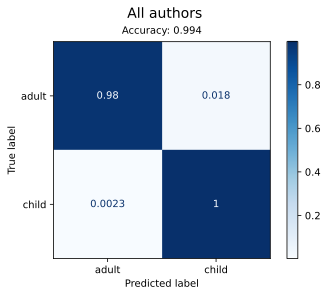

In [10]:
palette = sns.color_palette('gist_stern_r', as_cmap=True)
classes = [label for label in encoded_labels]
title = "All authors"

disp = ConfusionMatrixDisplay.from_estimator(
    gs,
    X_test,
    y_test,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize='true',
)

plt.suptitle(title, y=1, fontsize=14)
disp.ax_.set_title(f"Accuracy: {gs.best_score_:.3f}", fontsize=10, pad=8)
disp.ax_.tick_params(axis='x');

In [108]:
features_names = gs.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names_out()
clf = gs.best_estimator_.named_steps['linearsvc']

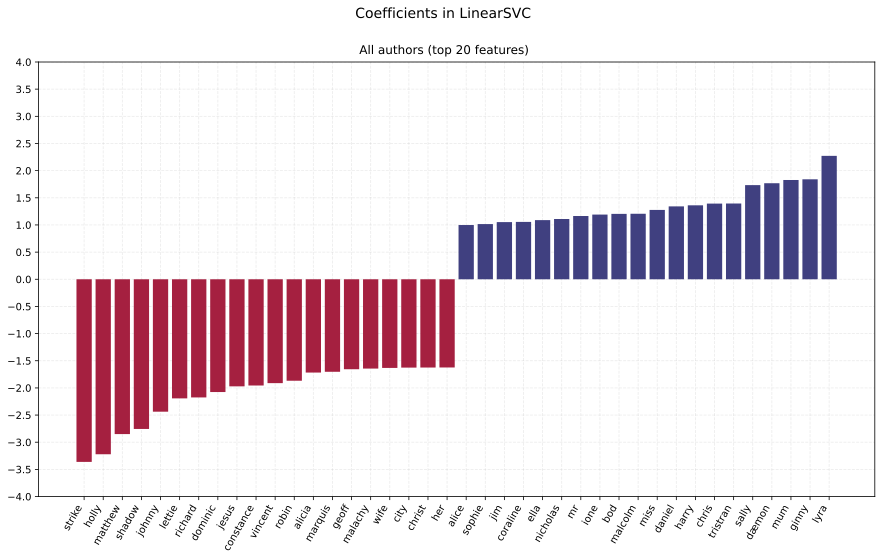

In [153]:
def plot_coefficients_v(classifier, feature_names, n_features=20):
    coef = classifier.coef_.ravel()
    top_pos_coefficients = np.argsort(coef)[-n_features:]
    top_neg_coefficients = np.argsort(coef)[:n_features]
    top_coefficients = np.hstack([top_neg_coefficients, top_pos_coefficients])
    plt.figure(figsize=(n_features * 0.75, 8))
    colors = ['#a52040' if c < 0 else '#404080' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_features), coef[top_coefficients], color=colors, zorder=2)
    feature_names = np.array(feature_names)
    plt.suptitle(f"Coefficients in {classifier.__class__.__name__}", y=.975, fontsize=14)
    plt.title(f"All authors (top {n_features} features)", x=.485, pad=8)
    plt.xticks(np.arange(0, 2 * n_features), feature_names[top_coefficients], ha='right', rotation=60)
    _, _, ymin, ymax = plt.axis()
    range = int(abs(ymin - ymax))
    step = 0.5
    plt.yticks(np.arange((range * -1), range + step, step))
    plt.ylim((range * -1) + 2, range - 2)
    plt.grid(axis='both', linestyle='--', alpha=.25, zorder=1)
    plt.show()

plot_coefficients_v(clf, features_names)